In [237]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [238]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\gold_annotation"

In [239]:
MOTION = "IDLE"

In [240]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

8


In [241]:
# Keeps values equal to 'X', changes everything else to 'Y'
df['motion_type'] = df['motion_type'].where(df['motion_type'] == f'{MOTION}', f'NOT_{MOTION}')

In [242]:
len(df)

269

In [243]:
df.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,gyro_x_1,gyro_y_1,gyro_z_1,accel_x_1,...,accel_x_4,accel_y_4,accel_z_4,gyro_x_5,gyro_y_5,gyro_z_5,accel_x_5,accel_y_5,accel_z_5,motion_type
0,0.094428,-0.720844,0.777013,0.89025,-12.843750,-2.612513,0.00000,0.000000,0.000000,0.00000,...,3.879000,-3.748950,-8.397000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_IDLE
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.05885,-0.298650,0.524517,5.39300,...,-76.785004,70.759056,21.894001,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_IDLE
2,0.073253,-0.283078,0.453750,4.65600,-12.122776,-1.741500,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_IDLE
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-2.06723,-0.871613,-6.555670,-12.05658,...,0.027000,-3.603000,3.202950,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_IDLE
4,0.000000,0.000000,0.000000,4.27395,-34.944000,-38.773052,0.65890,11.824312,-11.209413,6.69300,...,5.471475,-6.936975,-1.344000,0.109587,0.174694,0.17435,6.108525,-8.61555,-2.526975,NOT_IDLE


<Axes: xlabel='motion_type', ylabel='count'>

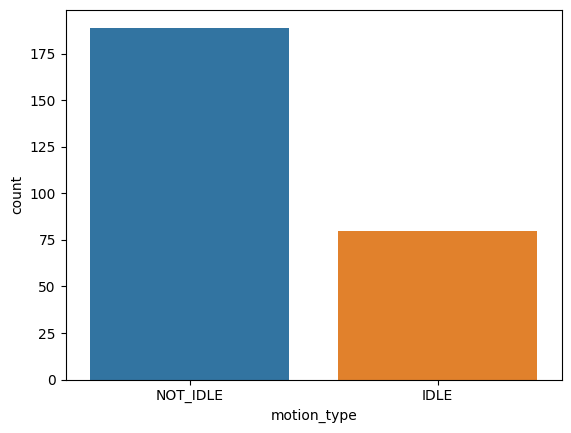

In [244]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [245]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [246]:
n_timesteps = 6
channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"]
n_channels = len(channels)

X = np.zeros((len(df), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X[:, c, t] = X_df[col_name].values

In [247]:
def left_zero_pad(X, target_timesteps=9):
    """
    X shape: (n_samples, n_channels, n_timesteps)
    """
    n_samples, n_channels, n_timesteps = X.shape
    pad = target_timesteps - n_timesteps

    if pad <= 0:
        return X

    padding = np.zeros((n_samples, n_channels, pad))
    X_padded = np.concatenate([padding, X], axis=2)
    return X_padded

In [248]:
X = left_zero_pad(X, target_timesteps=9)
print(X.shape)  # (n_samples, 6, 9)

(269, 6, 9)


In [249]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [250]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.33, random_state=42)

In [251]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [252]:
# clf_minirocket = make_pipeline(
#     MiniRocketMultivariate(random_state=42),
#     StandardScaler(with_mean=False),
#     RidgeClassifier(alpha=1.0)
# )
clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)
# clf_minirocket = InceptionTimeClassifier()

clf_minirocket.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier()

In [253]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf_minirocket.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9438202247191011
0.9649122807017544
0.9482758620689655
0.9565217391304348


In [254]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [255]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [256]:
scores_accuracy = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=f1_macro
)

In [257]:
print("MiniRocket Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("MiniRocket Precision:", scores_precision.mean(), "±", scores_precision.std())
print("MiniRocket Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("MiniRocket F1-score :", scores_f1.mean(), "±", scores_f1.std())

MiniRocket Accuracy : 0.8653594771241829 ± 0.07501833116432044
MiniRocket Precision: 0.8661255411255411 ± 0.05102168248628779
MiniRocket Recall   : 0.8841991341991342 ± 0.0552849192224722
MiniRocket F1-score : 0.8597214895303467 ± 0.07318807164539944


In [258]:
%%timeit
clf_minirocket.predict(np.expand_dims(X[0], axis=0))

12.4 ms ± 427 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


KNeighborsTimeSeriesClassifier (Euclidean)
3.48 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

KNeighborsTimeSeriesClassifier (DTW)
15.8 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

InceptionTimeClassifier
83 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)